In [11]:
from skimage import io
from natsort import natsorted, ns
import os
from skimage.util import view_as_blocks
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.color import rgb2gray,gray2rgb
import numpy as np
from Bicubic_interpolation.bicubic import bicubic
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

hr = [io.imread('./drive/MyDrive/Colab Notebooks/imgscale/hr/'+str(i)+'.bmp') for i in range(1,15)]
lr = [io.imread('./drive/MyDrive/Colab Notebooks/imgscale/lr/'+str(i)+'.bmp') for i in range(1,15)]

In [12]:
hr[0].shape

(480, 500, 3)

In [13]:
def get_blocks(i,size):
    block_shape = np.array(size)
    nblocks = np.array(i.shape) // block_shape  
    crop_r, crop_c = nblocks * block_shape
    cropped_img = i[:crop_r, :crop_c]
    return cropped_img

In [14]:
def get_abcd(i,size):
  block_shape = np.array(size)
  nblocks = np.array(i.shape) // block_shape  
  crop_r, crop_c = nblocks * block_shape
  cropped_img = i[:crop_r, :crop_c]
  Blocks = view_as_blocks(cropped_img, block_shape=size)
  return Blocks.shape

In [15]:
def get_patches(i,size):
    block_shape = np.array(size)
    nblocks = np.array(i.shape) // block_shape  
    crop_r, crop_c = nblocks * block_shape
    cropped_img = i[:crop_r, :crop_c]
    Blocks = view_as_blocks(cropped_img, block_shape=size)
    a,b,c,d = Blocks.shape
    return Blocks.reshape(a*b,c*d)

In [16]:
get_patches(rgb2gray(lr[2]),(7,7))

array([[113, 105, 170, ..., 150, 170, 170],
       [105, 105, 166, ..., 215, 223, 223],
       [215, 227, 231, ..., 117,  97, 121],
       ...,
       [ 57,  77,  65, ...,  45,  85,  45],
       [ 85,  65,  49, ..., 105,  49,  53],
       [ 77,  85,  93, ...,  61,  57,  97]], dtype=uint8)

In [17]:
hr_patches = [get_patches(rgb2gray(i), (21,21)) for i in hr]
lr_patches = [get_patches(rgb2gray(i), (7,7)) for i in lr]
mhr = np.vstack(hr_patches)
mlr = np.vstack(lr_patches)

In [18]:
mhr.shape

(7016, 441)

In [19]:
mlr.shape

(7016, 49)

In [20]:
for i in range(len(hr_patches)):
  if hr_patches[i].shape[0]!=lr_patches[i].shape[0]:
    print(i)

In [21]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=64, max_iter = 200, tol = 0.1)
km.fit(mlr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
       n_clusters=64, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.1, verbose=0)

In [22]:
import pickle
with open('clusters','wb') as f:
  pickle.dump(km,f)

In [23]:
with open('clusters','rb') as f:
  km = pickle.load(f)

In [24]:
km.cluster_centers_.shape

(64, 49)

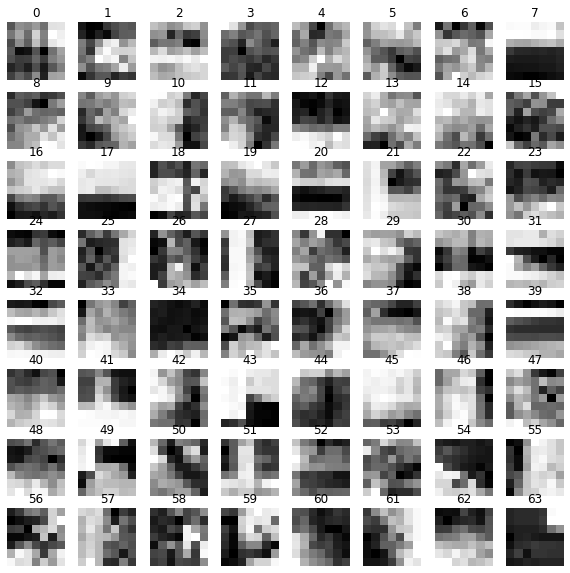

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
for i in range(64):
  fig.add_subplot(8,8,i+1)
  plt.imshow(km.cluster_centers_[i].reshape(7,7), cmap='gray')
  plt.axis('off')
  plt.title(str(i)) 
plt.show()

In [26]:
def addones(M):
  n,m = M.shape
  X0 = np.ones((n,1))
  return np.hstack((M,X0))

In [27]:
addones(np.array([[1,2,3],[4,5,6]]))

array([[1., 2., 3., 1.],
       [4., 5., 6., 1.]])

In [28]:
def solve(V,W):
  V = np.transpose(addones(V))
  W = np.transpose(W)
  C = np.matmul(np.matmul(W,np.transpose(V)),np.linalg.inv(np.matmul(V,np.transpose(V))))
  return C

In [29]:
def cids(clustNum, labels_array): 
    return list(np.where(labels_array == clustNum)[0])

In [30]:
all_coef = []
for i in range(64):
  ids = cids(i,km.labels_)
  v = mlr[ids, :]
  w = mhr[ids, :]
  try:
    S = solve(v,w)
    all_coef.append(solve(v,w))
  except:
    all_coef.append([])

In [37]:
test = io.imread('butterfly.png')
p = get_patches(rgb2gray(test),(7,7))
v = np.transpose(addones(np.array([p[0]])))
w = np.transpose(np.matmul(all_coef[0],v))
testo = w[0].reshape(21,21)
o = rgb2gray(bicubic(gray2rgb(p[0].reshape(7,7)),3,-1/2))

In [33]:
def get_hrp(lrp):
  v = np.transpose(addones(np.array([lrp])))
  pred = km.predict(np.array([lrp]))[0]
  if all_coef[pred]!=[]:
    w = np.transpose(np.matmul(all_coef[pred],v))
    return w[0]
  else:
    return rgb2gray(bicubic(gray2rgb(lrp.reshape(7,7)),3,-1/2)).reshape(441,)

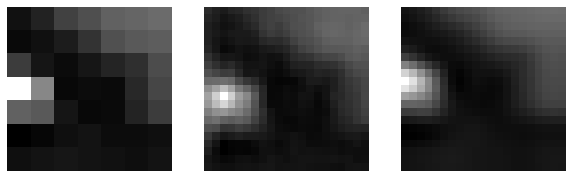

In [38]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1,3,1)
plt.imshow(p[0].reshape(7,7), cmap='gray')
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(testo, cmap='gray')
plt.axis('off')

fig.add_subplot(1,3,3)
plt.imshow(o, cmap='gray')
plt.axis('off')

plt.show()

In [39]:
def upscale_img(i):
  inp = io.imread(i)
  ps = get_patches(rgb2gray(inp),(7,7))
  a,b,c,d = get_abcd(rgb2gray(inp),(7,7))
  hs = np.array([get_hrp(p) for p in ps])
  q = rebuild(hs.reshape(a,b,21,21))
  return q
 

In [40]:
def rebuild(B):
  return B.swapaxes(1,2).reshape(-1,B.shape[1]*B.shape[3])

In [41]:
def test(img):
  test = rgb2gray(io.imread(img))
  u = upscale_img(img)

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), dpi=80, sharex=True, sharey=True)
  ax[1].imshow(test, cmap='gray')
  ax[0].imshow(u, cmap='gray')

  print(test.shape)
  print(u.shape)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removi

(453, 590)
(1344, 1764)


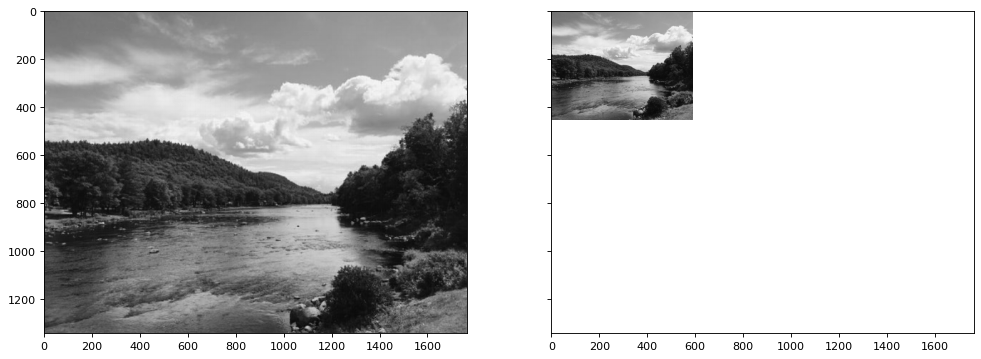

In [43]:
test('test.jpg')

In [ ]:
res = {}
for i in range(1,15):
  if i==3:
    continue
  orig = get_blocks(rgb2gray(hr[i-1]),(21,21))
  pred = np.array(upscale_img('./drive/MyDrive/Colab Notebooks/imgscale/lr/'+str(i)+'.bmp'))
  res[i] = [ssim(orig,pred),mean_squared_error(orig,pred)]


In [45]:
import pandas as pd
df = pd.DataFrame.from_dict(res,orient='index')
df

,0,1
1,0.616606,0.009822
2,0.806730,0.004400
4,0.713286,0.004578
5,0.747840,0.008731
6,0.867087,0.000999
7,0.833176,0.004018
8,0.917116,0.002325
9,0.891794,0.001503
10,0.799559,0.003855
11,0.928247,0.002361


In [56]:
df.columns = ['ssim','mse']
df.describe()

,ssim,mse
count,13.000000,13.000000
mean,0.825473,0.004385
std,0.089739,0.002790
min,0.616606,0.000999
25%,0.799559,0.002325
50%,0.833600,0.004018
75%,0.891794,0.004578
max,0.928247,0.009822


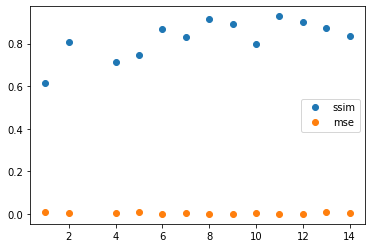

In [57]:
df.plot(style='o')